In [297]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from dotenv import load_dotenv
from typing import TypedDict, Annotated, Literal
from pydantic import BaseModel, Field
import operator
import ipywidgets as widgets
from IPython.display import display,Image,Markdown


In [298]:
load_dotenv()
post_generator=ChatOpenAI(model="gpt-4o-mini")
post_evaluator=ChatOpenAI(model="gpt-4o-mini")
post_optimizer=ChatOpenAI(model="gpt-4o-mini")

In [299]:
class PostState(TypedDict):
    topic:str
    final_post:str
    evaluation:Literal["accepted","needs_improvement"]
    evaluation_feedback:str
    iteration_count:Annotated[int,Field(default=0)]
    max_iteration:int
    post_history:Annotated[list[str],operator.add]
    feedback_history:Annotated[list[str],operator.add]

In [300]:
class EvaluationSchema(BaseModel):
    evaluation:Annotated[Literal["accepted","needs_improvement"],Field(description="THis tell whether the post need improvement or is accepted.")]
    evaluation_feedback:Annotated[str,Field(description="This the the feedback we will get after the evaluation of the post.")]

structured_post_evaluator=post_evaluator.with_structured_output(EvaluationSchema)

In [301]:
def generate_post(state:PostState)->PostState:
    messages=[
        SystemMessage(content="""You have to act as LinkedIn content writter. 
    You will pe provided with the template on which previously linkedIn post were wittren and you have to identify the tone and systax of that post and then You have to generate a new Post following that syntax.
    This is my previous post syntax.
    📌 LangGraph Learning Journey – Post #2: **Practicing Conditional Workflows**
    Continuing my exploration of LangGraph, I decided to dive into conditional workflows — and built an AI Resume Screener to test it out.
    It analyzes resumes and job descriptions, checks for tone, qualification match, and red flags, and then routes each application through different decision paths — generating personalized responses based on the outcome.
    Through this project, I got hands-on with:
    - Conditional edges and branching logic
    - State schema design for variable input
    - Multi-step decisions using LLMs
    Still early in the journey, but each small build is a new step forward. Always learning, always iterating. 🚀
    🎥 I’ve made a quick video demo (posting it with this).
    📂 GitHub: https://rebrand.ly/5brlgjh
    If you’re working with LangGraph, agentic flows, or LLM tools, let’s connect!
    hashtag#LangGraph hashtag#LangChain hashtag#AI hashtag#LLMs hashtag#AgenticWorkflows hashtag#LearningInPublic hashtag#GrowthMindset hashtag#ResumeScreening hashtag#OpenAI """),
            HumanMessage(content=f"""
    Write a linkedIn post following the template. In this topic you will be provided with the post number, and what is the work he has done. and you have to make the Linkedin post.
    Topic: {state['topic']}

    """)]
    response=post_generator.invoke(messages)
    
    return {
        "final_post":response.content,
        "post_history":[response.content]
    }


In [302]:
def evaluate_post(state:PostState)->PostState:
    template=PromptTemplate(
        template="""
You will be provided with 2 posts. First one is the previous post that I did on linkedIn and sencond is the fresh generated post.
What you have to do is to evaluate the post based on the systax of post 1. If the post is accurate you have to provide outout as follows:
- Evaluation: accepted
- evaluation_feedback: The feedback why you accepted this post. 
But is the post you made is not good the you have to give output as follows:
- Evaluation: needs_improvement
- evaluation_feedback: The detailed feedback which can help to make this post to get accepted according to the given criteria.
Post 1 syntax:
    📌 LangGraph Learning Journey – Post #2: Practicing Conditional Workflows
    Continuing my exploration of LangGraph, I decided to dive into conditional workflows — and built an AI Resume Screener to test it out.
    It analyzes resumes and job descriptions, checks for tone, qualification match, and red flags, and then routes each application through different decision paths — generating personalized responses based on the outcome.
    Through this project, I got hands-on with:
    - Conditional edges and branching logic
    - State schema design for variable input
    - Multi-step decisions using LLMs
    Still early in the journey, but each small build is a new step forward. Always learning, always iterating. 🚀
    🎥 I’ve made a quick video demo (posting it with this).
    📂 GitHub: https://rebrand.ly/5brlgjh
    If you’re working with LangGraph, agentic flows, or LLM tools, let’s connect!
    hashtag#LangGraph hashtag#LangChain hashtag#AI hashtag#LLMs hashtag#AgenticWorkflows hashtag#LearningInPublic hashtag#GrowthMindset hashtag#ResumeScreening hashtag#OpenAI
Fresh Generated Post:
    {post}

**Important Note**: 
- If the post start doesn't mention what i am practicing and mentions the tool i have made. You have to reject that post.
- If the post length exceeds from 150 words reject it. 
- If the content tone of generated is different from the given post then also reject it.
- using same tone is very necessary. Make a seperate portion in feedback so that the tone and syntax of the post doesn't change
""",input_variables=["post"]
    )
    chain=template|structured_post_evaluator
    response=chain.invoke({
        "post":state["final_post"]
    })
    return {
        "evaluation":response.evaluation,
        "evaluation_feedback":response.evaluation_feedback,
        "feedback_history":[response.evaluation_feedback]
    }

In [303]:
def post_router(state:PostState)->Literal['accepted','needs_improvement']:
    if state['iteration_count']>=state["max_iteration"] or state['evaluation']=="accepted":
        return "accepted"
    else:
        return "needs_improvement"

In [304]:
def optimize_post(state:PostState)->PostState:
    prompt=PromptTemplate(
        template="""
    You will be provided with the post that was previously rejeceted due to some flaws and also with the feedack that can help you to regenerate the post that falls of the criteria. 
    You have to generate the new post.

    Post: {post}
    Feedback provided: {feedback}

""",input_variables=['post','feedback']
    )
    chain=prompt|post_optimizer
    response=chain.invoke({
        "post":state['final_post'],
        "feedback":state["evaluation_feedback"]
    })
    return{
        "final_post":response.content,
        "post_history":[response.content],
        "iteration_count":state["iteration_count"]+1
    }

In [305]:
graph=StateGraph(PostState)
graph.add_node(generate_post,"generate_post")
graph.add_node(evaluate_post,"evaluate_post")
graph.add_node(optimize_post,"optimize_post")

graph.add_edge(START,"generate_post")
graph.add_edge("generate_post","evaluate_post")
graph.add_conditional_edges("evaluate_post",post_router,{"accepted":END,"needs_improvement":"optimize_post"})
graph.add_edge("optimize_post","evaluate_post")

In [306]:
workflow=graph.compile()

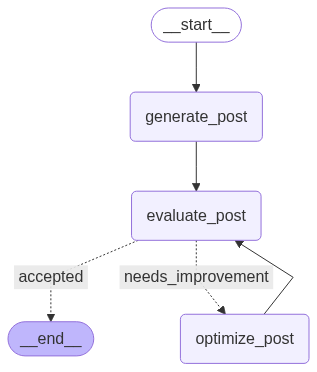

In [307]:
Image(workflow.get_graph().draw_mermaid_png())

In [308]:
text_area = widgets.Textarea(
    placeholder='Type your input here',
    description='Enter Topic with its description:',
    layout=widgets.Layout(width='800px', height='200px')
)

display(text_area)

user_input = ""
def get_input(b):
    global user_input
    user_input = text_area.value
button = widgets.Button(description="Submit")
display(button)

button.on_click(get_input)


Textarea(value='', description='Enter Topic with its description:', layout=Layout(height='200px', width='800px…

Button(description='Submit', style=ButtonStyle())

In [309]:
final_state=workflow.invoke({
    "topic":user_input,
    "max_iteration":3,
    "iteration_count":0
})

In [310]:
Markdown(final_state['final_post'])

📌 LangGraph Learning Journey – Post #3: **Exploring Iterative Workflows**

Today, my focus was on enhancing my skills in content creation through iterative workflows. I practiced building a Linked Post Generator that creates topic-specific posts and evaluates them using feedback from another AI model.

Here's how it works: If the post meets the criteria, it’s complete; if not, it goes into an optimization phase. This cycle leads to continuous improvement and valuable insights.

In this process, I've been utilizing:
- Iterative edges for seamless development
- One-shot prompting for fast drafts
- Tree of thought prompting for innovative ideas

I'm thrilled to keep evolving in this journey! 🚀

📂 GitHub: [Your GitHub Link Here]

If you're interested in iterative workflows, feel free to reach out!

#LangGraph #AI #IterativeWorkflows #LearningInPublic #ContentCreation

In [311]:
final_state['iteration_count']

3